In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output
import time

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

2023-06-24 16:38:56.002153: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-24 16:38:56.050401: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-24 16:38:56.050914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-24 16:38:56.873564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


# Cargar datos

In [2]:
Train = pd.read_csv("Database/TrainSample.csv")
Test = pd.read_csv("Database/TestSample.csv")

In [23]:
XTrain = np.array(Train[['PhiNorm','ThetaNorm']])
YTrain = np.array(Train['Tipo'])
XTest = np.array(Test[['PhiNorm','ThetaNorm']])
YTest = np.array(Test['Tipo'])

# Arquitectura de la red

In [4]:
X = tf.placeholder('float', shape=[None, XTrain.shape[1]], name='input1')
Y = tf.placeholder('float', shape=[None], name='input2')
print(X.shape,Y.shape,X.name,Y.name)

(?, 2) (?,) input1:0 input2:0


# Neuronas por capa y learning rate

In [5]:
lr = 0.03
NN = [2,4,8,4,1]

In [6]:
# Capa 1
W1 = tf.Variable( tf.random.normal([NN[0],NN[1]]), name='Weights_1' )
b1 = tf.Variable( tf.random.normal([NN[1]]), name='Bias_1' )
l1 = tf.nn.relu(tf.add(tf.matmul(X,W1),b1))

In [7]:
# Capa 2
W2 = tf.Variable( tf.random.normal([NN[1],NN[2]]), name='Weights_2' )
b2 = tf.Variable( tf.random.normal([NN[2]]), name='Bias_2' )
l2 = tf.nn.relu(tf.add(tf.matmul(l1,W2),b2))

In [8]:
#Capa3
W3 = tf.Variable( tf.random.normal([NN[2],NN[3]]),name='Weights_3' )
b3 = tf.Variable( tf.random.normal([NN[3]]), name='Bias_3' )
# El output debe ser sigmoide para tener acotada la salida
lout = tf.nn.sigmoid(tf.add(tf.matmul(l2,W3),b3))[:,0]

In [9]:
print(lout)

Tensor("strided_slice:0", shape=(?,), dtype=float32)


# Función de costo

In [10]:
loss = tf.losses.mean_squared_error(lout,Y)

# Optimizador

In [11]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

# Sesión de tensorflow

Step 99000 / 100000 -Loss =  0.035660967  -Acc  0.9666666666666667


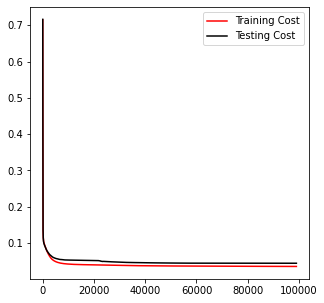

In [12]:
sess = tf.Session()

saver = tf.train.Saver()

n_steps = int(1e5)

#init = tf.global_variables_initializer()

LossTrain = np.array([])
LossTest = np.array([])

with sess.as_default():
    
    #sess.run(init)
    tf.global_variables_initializer().run()
    
    for i in range(n_steps):
        
        # Optimización
        _, _lossTrain, _pY = sess.run( [optimizer,loss,lout], feed_dict={X:XTrain,Y:YTrain} )
        _lossTest, _pYT = sess.run( [loss,lout], feed_dict={X:XTest,Y:YTest} )
        
        LossTrain = np.append(LossTrain,_lossTrain)
        LossTest = np.append(LossTest,_lossTest)
        
        if _lossTrain < 0.01 or np.abs( LossTrain[-1]-LossTest[-1] ) > 0.2:
            print('Entrenamiento Finalizado')
            break
            
        if i%1000 == 0:
            
            
            acc = np.mean( np.round(_pY) == YTrain )
            
            clear_output(wait=True)
            
            print('Step',i,'/',n_steps,'-Loss = ', _lossTrain, ' -Acc ', acc)
    
            fig = plt.figure(figsize=(5,5))
            ax = fig.add_subplot(111)
            
            ax.plot(LossTrain[:i],color='r',label='Training Cost')
            ax.plot(LossTest[:i],color='k',label='Testing Cost')
    
            ax.legend()
        
            plt.show()
        
            time.sleep(0.01)
    
    save_path = saver.save(sess,'Modelo1.ckpt')

# Predicción

In [20]:
sess.run(lout,feed_dict={X:[[0.8,0.4]]})

array([0.00196533], dtype=float32)

In [24]:
YTrain = YTrain[:,np.newaxis]
#YTrain

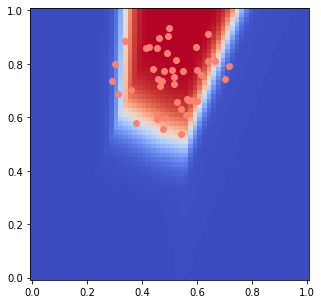

In [26]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
        
N = 60
        
x = np.linspace(0.,1.,N)
y = np.linspace(0.,1.,N) 

Y = np.zeros((N,N))

for i, _x in enumerate(x):
    for j, _y in enumerate(y):
        Y[i,j] = sess.run(lout,feed_dict={X:[[_x,_y]]})
        
ax.pcolormesh(x,y,Y.T,cmap='coolwarm')
ax.scatter(XTrain[YTrain[:,0] == 1 ,0],XTrain[YTrain[:,0]==1,1], c='salmon')

In [16]:
#sess.close()